In [11]:
import mdtraj as md
from writhe_tools.writhe import Writhe
from writhe_tools.tcca import tCCA
from writhe_tools.utils import cleanup, split_list, get_segments, gpu_stats, sort_indices_list
from writhe_tools.stats import Kmeans
from writhe_tools.md_tools import ResidueDistances, get_residues
import matplotlib.pyplot as plt
import numpy as np
from writhe_tools.stats import pmf

In [12]:
traj = md.load("/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd",
               top="/home/t/writhe/actr/actr.pdb").center_coordinates()
xyz = traj.atom_slice(traj.top.select("name CA")).xyz
segments = get_segments(71, tensor=True)
residues = get_residues(traj)

 # Instantiate an instance of the writhe class with the coordinates to use in the calculation

In [3]:
writhe = Writhe(xyz=xyz)

 ## Compute the writhe using segment length=1 and speed test
 ### Here, the protein has 71 residues and the simulation has ~30,000 frames
 ### compute writhe using parallelized cpu computation

In [4]:
writhe.compute_writhe(length=1, speed_test=True)

2024-09-29 23:52:29,176	INFO worker.py:1636 -- Started a local Ray instance.


Time elapsed : 10.122367143630981 s


 ## Utilize cuda enabled GPUs
#### multiple GPUs will be used if available and computation is large enough to warrant their usage (i.e. faster to use them, determined internally)
### Here, we just use 1 GPU

In [5]:
writhe.compute_writhe(length=1, speed_test=True, cuda=True)
cleanup() # when using GPUs in jupyter, need to be careful about memory

Time elapsed : 1.7860217094421387 s


   ### Now we compute without the speed test and store the results in the class. The results of the calculation are also returned as a dictionary. The class will store the results of a calculation by default but this behavior can be controlled by the store_results parameter. The stored results can then be easily saved.

In [ ]:
writhe.compute_writhe(length=1, speed_test=False, cuda=True, store_results=True)
# save the result
writhe.save(dir="./example_results", dscr="actr") #class will give the saved result an appropriate name with the description

 ## we made a directory called example results. Here's the pickled python dictionary file 

In [12]:
# find saved results on computer
!ls example_results | grep writhe_data_dict_length_1

actr_writhe_data_dict_length_1.pkl


### Now, let's compute the writhe for a series of different segment lengths and save our results


In [ ]:
from writhe_tools.utils import Timer
with Timer():
    for length in range(2, 6):
        writhe.compute_writhe(length, cuda=True)
        writhe.save(dir="./example_results", dscr="actr") # class save file name that includes length

In [15]:
# find saved results on computer
!ls example_results | grep writhe_data_dict

actr_writhe_data_dict_length_1.pkl
actr_writhe_data_dict_length_2.pkl
actr_writhe_data_dict_length_3.pkl
actr_writhe_data_dict_length_4.pkl
actr_writhe_data_dict_length_5.pkl


 # visualize the results of the calculations

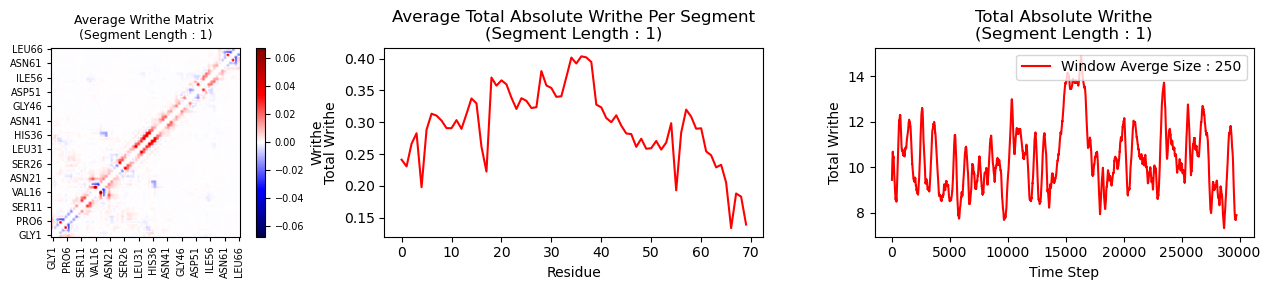

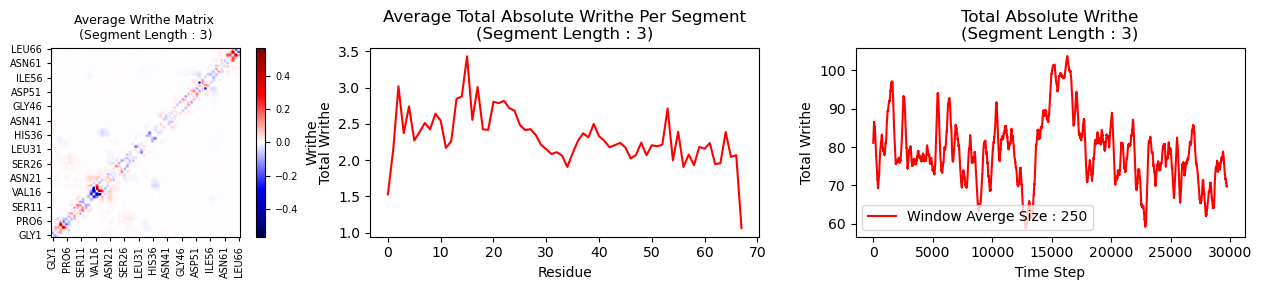

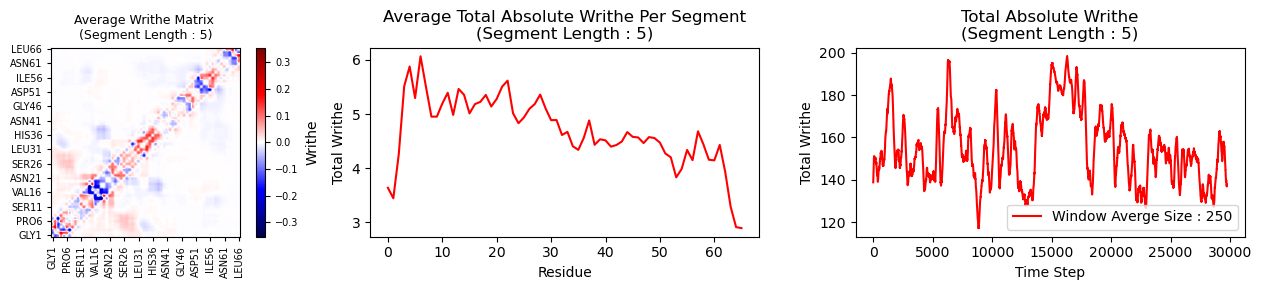

In [13]:
for length in [1, 3, 5]:    
    # restore the results of the calculation
    writhe = Writhe.load(f"example_results/actr_writhe_data_dict_length_{length}.pkl")
    # note that restoring the class will not restore the coordinates used in the calulation just the results.
    fig, axes = plt.subplots(1, 3, figsize=(14, 3))
    ax=axes.flat
    writhe.plot_writhe_matrix(ax=ax[0], xticks=residues, yticks=residues, label_stride=5)
    writhe.plot_writhe_per_segment(ax=ax[1])
    writhe.plot_writhe_total(ax=ax[2], window=250)
    fig.tight_layout()

 ## Note that ensemble averaging the writhe matrix often leads to sparse results for dynamic proteins as isotropic changes in crossings can result in a mean near zero
 ### Let's cluster the simulation frames and look that writhe matrices average over representative structures from each state.
 ###  Perform tCCA, cluster, look at average writhe matrices for 8 clusters

In [19]:
writhe = writhe.load("./example_results/actr_writhe_data_dict_length_1.pkl")

In [49]:
tcca = tCCA(
    np.concatenate([Writhe.load("example_results/actr_writhe_data_dict_length_1.pkl").writhe_features,
                    Writhe.load("example_results/actr_writhe_data_dict_length_3.pkl").writhe_features], 1),
            lag=35, dim=10)

proj = tcca.fit_transform()
dtraj, frames = Kmeans(proj, n_clusters=12, n_dim=5)
obs = abs(writhe.writhe_features).sum(-1)
frames = sort_indices_list(frames, obs)
indices = np.array([obs[i].mean() for i in frames]).argsort()[::-1]
frames = [frames[i] for i in indices]

### Compute distances, perform tCCA

In [21]:
distances = ResidueDistances(index_0=np.arange(71), traj=traj, chain_id_0="ACTR")
# WARNING ; this class computes distances in its init statement

# perform tCCA, project distances
distance_tcca = tCCA(data=distances.distances, lag=35, dim=10)
distances_proj = distance_tcca.fit_transform()

# optionally save results
distances.save("./example_results/distances_data_dict.pkl")

# then the distances class can be restored for analysis / plotting
distances = ResidueDistances.load("./example_results/distances_data_dict.pkl")


In [11]:
# saved result file for the distances
!ls example_results | grep distances

distances_data_dict.pkl


 ### Compare the writhe, contacts and distances for each cluster

In [54]:
from importlib import reload
import writhe_tools
reload(writhe_tools)
reload(writhe_tools.utils)
from writhe_tools.utils import reindex_list

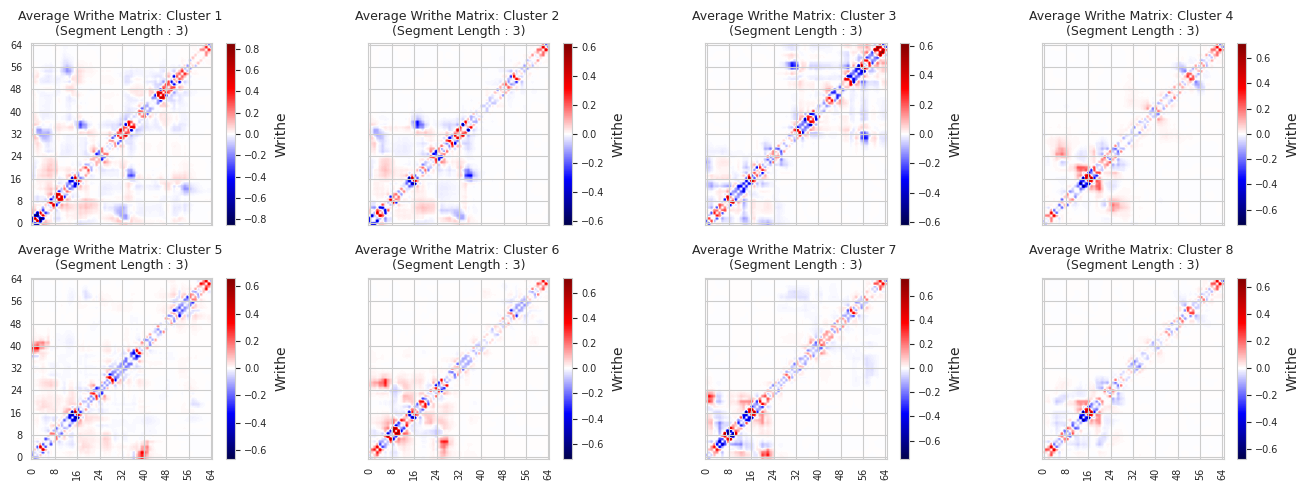

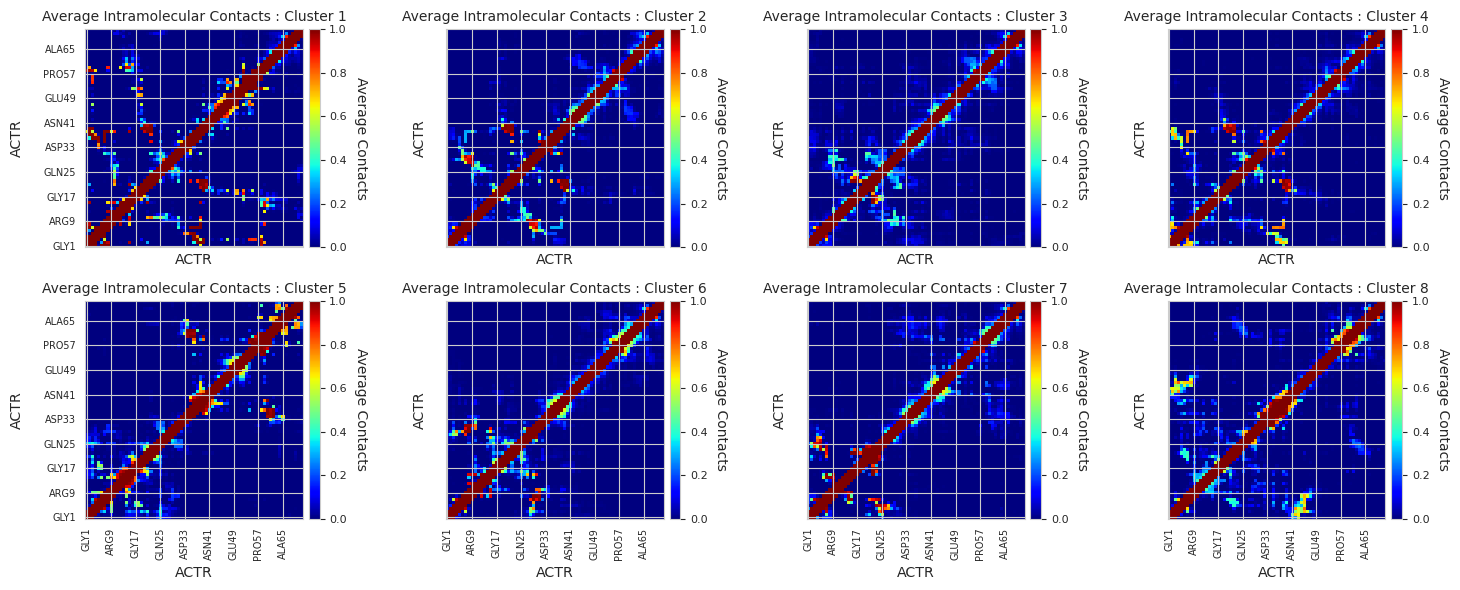

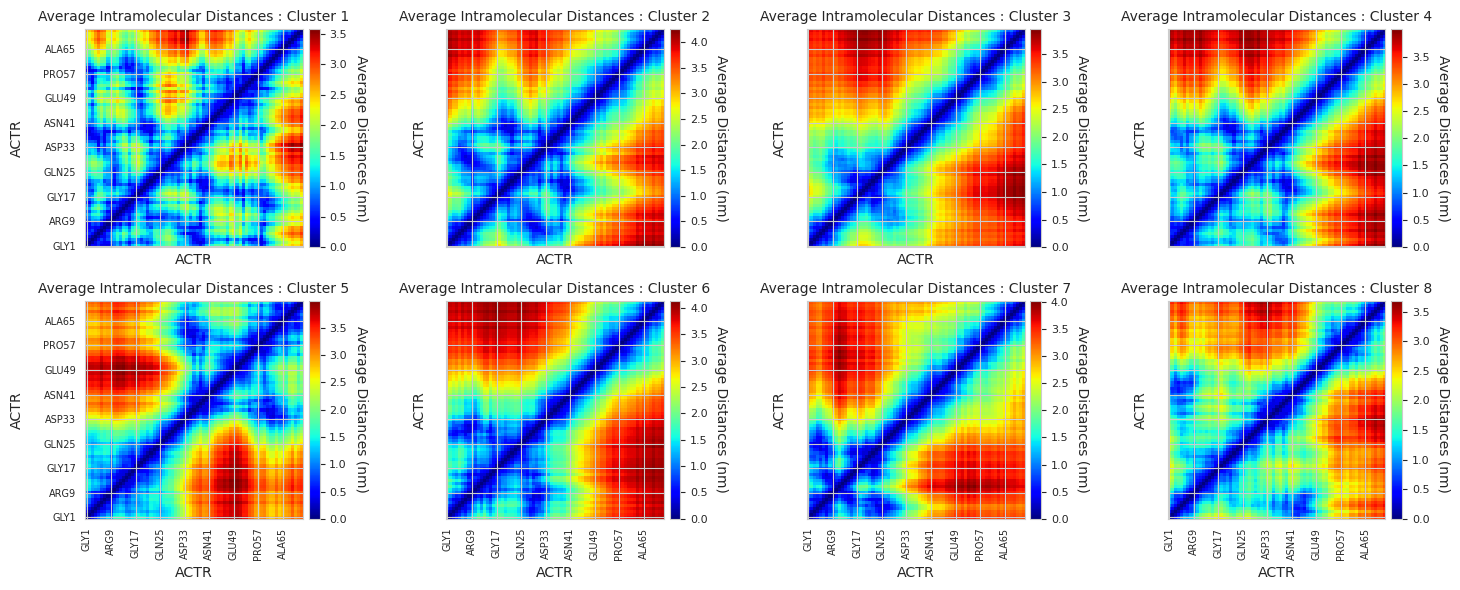

In [57]:
writhe = Writhe.load("example_results/actr_writhe_data_dict_length_3.pkl")
states = [0, 3, 4, 2, 7,  5, 6, 8]
# plot writhe for clusters
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(14, 5))
for index, (i, ax) in enumerate(zip(reindex_list(frames, states), axes.flat)):
    writhe.plot_writhe_matrix(index=i, ax=ax, label_stride=8, dscr=f"Cluster {index+1}")
fig.tight_layout()


# plot contacts for same clusters
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15, 6))
for index, (i, ax) in enumerate(zip(frames[:5000], axes.flat)):
    distances.plot(index=i, ax=ax, label_stride=8, dscr=f"Cluster {index+1}", contacts=True)
fig.tight_layout()


# plot distances for same clusters
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15, 6))
for index, (i, ax) in enumerate(zip(frames[:10], axes.flat)):
    distances.plot(index=i, ax=ax, label_stride=8, dscr=f"Cluster {index+1}")
fig.tight_layout()



 # Let's compare the distances and writhe tCCA projections
    

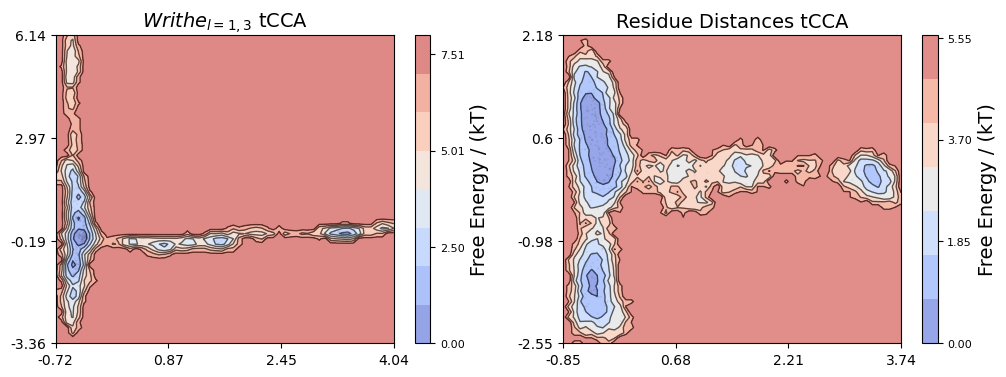

In [122]:
from writhe_tools.plots import fes2d


fig, axes = plt.subplots(1, 2, figsize= (12, 4))
ax = axes.flat


fes2d(proj[:, :2],
      bins=60,
      contour_lines=True,
      n_contours=8,
      scatter=True,
      mask=False,
      cmap="coolwarm",
      alpha_contours=.6,
      ax=ax[0],
      title=r"$Writhe_{l=1,3}$ tCCA",
      )

fes2d(
      distances_proj[:, :2],
      bins=60,
      contour_lines=True,
      n_contours=8,
      scatter=True,
      mask=False,
      cmap="coolwarm",
      alpha_contours=.6,
      ax=ax[1],
      title="Residue Distances tCCA",
      )

 ### We see that the writhe projection leads to a free energy surface with many more basins, allowing us to isolate more structurally distinct, metastable states. The axis labels also tell us that the writhe reactions coordinates have greater kinetic variance. 
 
 ### Let's compare those kinetic variances summed over the first ten components (VAMP2 score)


In [13]:
print(f"Writhe tCCA kinetic variance (VAMP2 score) : {np.sum(tcca.svals**2):.1f}")
print(f"Distances tCCA kinetic variance (VAMP2 score) : {np.sum(distance_tcca.svals**2):.1f}")

Writhe tCCA kinetic variance (VAMP2 score) : 9.9
Distances tCCA kinetic variance (VAMP2 score) : 9.3


 ### let's examine the densities of the latent spaces on the strips  that run along the reaction coordinates. 
 
 

In [59]:
# we'll use the data from writhe (l=1) to match the paper figure
proj = np.load("./example_results/writhe_tcca_proj_length_1_lag_31.npy")

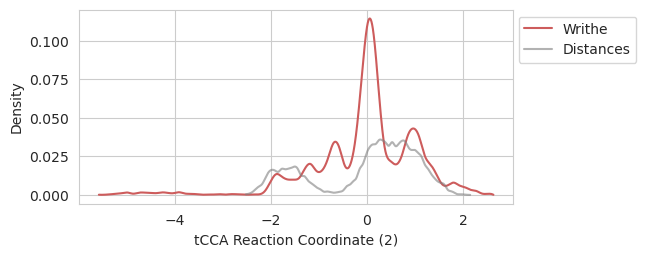

In [60]:
from scipy import interpolate
scale = 1.4
figsize = np.array([4, 1.8]) * scale
plt.figure(figsize=figsize)
idx = proj[:, 0] < -.1
bins=70
p, _, _, edges = pmf(proj[:, 1][idx], bins, norm=True,)
f = interpolate.interp1d(edges, p, kind="cubic")
x = np.linspace(edges[0], edges[-1], 10000)
plt.plot(x, f(x), color='indianred', label="Writhe")
p, _, _, edges = pmf(distances_proj[:, 1][idx], bins, norm=True)
f = interpolate.interp1d(edges, p, kind="cubic")
x = np.linspace(edges[0], edges[-1], 10000)
plt.plot(x, f(x), color="gray", alpha=.6, label="Distances", )
plt.xlabel("tCCA Reaction Coordinate (2)")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=[1.3,1])